In [1]:
import numpy as np
import copy

class LinearRegressor:
    """
    Extended Linear Regression model with support for categorical variables and gradient descent fitting.
    """

    def __init__(self, kernel = False):
        self.coefficients = None
        self.intercept = None
        self.kernel = kernel
        self.Z = None
    """
    This next "fit" function is a general function that either calls the *fit_multiple* code that
    you wrote last week, or calls a new method, called *fit_gradient_descent*, not implemented (yet)
    """
    def fit(self, X, y, method="least_squares", learning_rate=0.01, iterations=1000, mini_batch_size = None, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):
        """
        Fit the model using either normal equation or gradient descent.

        Args:
            X (np.ndarray): Independent variable data (2D array).
            y (np.ndarray): Dependent variable data (1D array).
            method (str): method to train linear regression coefficients. 
                          It may be "least_squares" or "gradient_descent".
            learning_rate (float): Learning rate for gradient descent.
            iterations (int): Number of iterations for gradient descent.

        Returns:
            None: Modifies the model's coefficients and intercept in-place.
        """
        if method not in ["least_squares", "gradient_descent", "adam"]:
            raise ValueError(f"Method {method} not available for training linear regression.")
        if np.ndim(X) == 1:
            X = X.reshape(-1, 1)
        
        X_with_bias = np.insert(X, 0, 1, axis=1)  # Adding a column of ones for intercept

        if method == "least_squares":
            self.fit_multiple(X_with_bias, y)
        elif method == "gradient_descent":
            self.fit_gradient_descent(X_with_bias, y, learning_rate, iterations, mini_batch_size)
        elif method == "adam":
            self.fit_adam_optimization(X_with_bias, y, learning_rate, iterations, mini_batch_size, beta1, beta2, epsilon)
    
    def fit_multiple(self, X, y):
        """
        Fit the model using multiple linear regression (more than one independent variable).

        This method applies the matrix approach to calculate the coefficients for
        multiple linear regression.

        Args:
            X (np.ndarray): Independent variable data (2D array), with bias.
            y (np.ndarray): Dependent variable data (1D array).

        Returns:
            None: Modifies the model's coefficients and intercept in-place.
        """
        # This code replaces the code you had last week. 
        # If you want, feel free to paste here your code! 
        
        X_transpose = np.transpose(X)
        X_transpose_dot_X = X_transpose.dot(X)
        inverse_X_transpose_dot_X = np.linalg.inv(X_transpose_dot_X)
        X_transpose_dot_y = X_transpose.dot(y)

        coefficients = inverse_X_transpose_dot_X.dot(X_transpose_dot_y)
        
        
        # Store the intercept and the coefficients of the model
        self.intercept = coefficients[0]
        self.coefficients = coefficients[1:]

    def kernel_func(self, x, z):
        return np.exp(- np.linalg.norm(x - z, 2) / (2*0.001))

    def create_kernel(self, X) -> None:
        self.X = X
        n = X.shape[0]
        self.Z = np.zeros((n, n))
        for i in range(n):
            for j in range(i, n):
                self.Z[i, j] = self.kernel_func(X[i], X[j])  # self.X[i].T @ self.X[j]
                if i != j:
                    self.Z[j, i] = self.Z[i, j]

    def fit_gradient_descent(self, X, y, learning_rate=0.01, iterations=1000,mini_batch_size = 64):
        """
        Fit the model using either normal equation or gradient descent.

        Args:
            X (np.ndarray): Independent variable data (2D array), with bias.
            y (np.ndarray): Dependent variable data (1D array).
            learning_rate (float): Learning rate for gradient descent.
            iterations (int): Number of iterations for gradient descent.

        Returns:
            None: Modifies the model's coefficients and intercept in-place.
        """
        
        # Initialize the parameters to very small values (close to 0)
        m = len(y)
        if mini_batch_size is None or mini_batch_size > m:
            mini_batch_size = m

        if self.kernel:
            self.X = X
            self.create_kernel(X)
            self.alphas = np.random.rand(X.shape[0]) * 0.01

        self.coefficients = np.random.rand(X.shape[1] - 1) * 0.01  # Small random numbers
        self.intercept = np.random.rand() * 0.01

        losses = []
        coeffs = []
        for epoch in range(iterations):
            if not self.kernel:
                for mini_batch_X, mini_batch_y in self.get_minibatches(X, y, mini_batch_size):
                    coeffs.append((copy.deepcopy(self.coefficients), copy.deepcopy(self.intercept) if isinstance(self.intercept, list) else [self.intercept]))

                    if not self.kernel:
                        predictions =  mini_batch_X.dot(np.insert(self.coefficients, 0, self.intercept))

                        error = predictions - mini_batch_y
                        
                        # TODO: Write the gradient values and the updates for the paramenters
                        gradient = (2 * np.matmul(mini_batch_X.T, predictions) - 2 * np.matmul(mini_batch_X.T, mini_batch_y))/m

                        self.intercept -= learning_rate * gradient[0]
                        self.coefficients -= learning_rate * gradient[1:]





                # TODO: Calculate and print the loss every 10 epochs
                if epoch % 10 == 0:

                    mse = np.sum(np.matmul(error.T, error))/m
                    losses.append(mse)
                    # print(f"Epoch {epoch}: MSE = {mse}")
            else:
                n = len(self.alphas)
                new_alphas = np.zeros_like(self.alphas)
                for k in range(0, n):
                    grad = 0
                    for j in range(0, n):
                        suma = 0
                        for i in range(0, n):
                            suma += self.alphas[i] * self.Z[i, j]
                        grad += (y[j] - suma) * self.Z[k,j]
                    new_alphas[k] = self.alphas[k] - learning_rate * (-1/n) * grad
                print(epoch)
                self.alphas = new_alphas
        # plot_losses(losses, "Gradient Descent", mini_batch_size)
        # if len(self.coefficients) == 1:
            # plot_contour(X, y, coeffs, "Gradient Descent", mini_batch_size, w_range=[-3, 3, 0.1], b_range=[-3, 3, 0.1])


    def fit_adam_optimization(self, X, y, learning_rate=0.01, iterations=1000, mini_batch_size = None, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):
        """
        Fit the model using either normal equation or gradient descent.

        Args:
            X (np.ndarray): Independent variable data (2D array), with bias.
            y (np.ndarray): Dependent variable data (1D array).
            learning_rate (float): Learning rate for gradient descent.
            iterations (int): Number of iterations for gradient descent.

        Returns:
            None: Modifies the model's coefficients and intercept in-place.
        """
        
        # Initialize the parameters to very small values (close to 0)
        m = len(y)
        if mini_batch_size is None or mini_batch_size > m:
            mini_batch_size = m


        self.coefficients = np.random.rand(X.shape[1] - 1) * 0.01  # Small random numbers
        self.intercept = np.random.rand() * 0.01


        losses = []
        V_dw = 0
        S_dw = 0

        V_db = 0
        S_db = 0

        coeffs = []
        for epoch in range(iterations):
            for mini_batch_X, mini_batch_y in self.get_minibatches(X, y, mini_batch_size):
                coeffs.append((copy.deepcopy(self.coefficients), copy.deepcopy(self.intercept) if isinstance(self.intercept, list) else [self.intercept]))

                predictions = mini_batch_X.dot(np.insert(self.coefficients, 0, self.intercept))

                error = predictions - mini_batch_y
                # TODO: Write the gradient values and the updates for the paramenters

                gradient = (2 * np.matmul(mini_batch_X.T, predictions) - 2 * np.matmul(mini_batch_X.T, mini_batch_y))/m

                db = gradient[0]
                dw = gradient[1:]

                V_dw = beta1 * V_dw + (1 - beta1) * dw
                V_db = beta1 * V_db + (1 - beta1) * db

                S_dw = beta2 * S_dw + (1 - beta2) * dw**2
                S_db = beta2 * S_db + (1 - beta2) * db**2

                V_corrected_dw = V_dw / (1 - beta1**(epoch + 1))
                V_corrected_db = V_db / (1 - beta1**(epoch + 1))

                S_corrected_dw = S_dw / (1 - beta2**(epoch + 1))
                S_corrected_db = S_db / (1 - beta2**(epoch + 1))

                self.intercept -= learning_rate * V_corrected_db / (np.sqrt(S_corrected_db) + epsilon)
                self.coefficients -= learning_rate * V_corrected_dw / (np.sqrt(S_corrected_dw) + epsilon)

            # TODO: Calculate and print the loss every 10 epochs
            if epoch % 10 == 0:
                mse = np.sum(np.matmul(error.T, error))/m
                losses.append(mse)
                # print(f"Epoch {epoch}: MSE = {mse}")
        
        # plot_losses(losses, "Adam", mini_batch_size)
        # if len(self.coefficients) == 1:
            # plot_contour(X, y, coeffs, "Adam", mini_batch_size,  w_range=[-3, 3, 0.1], b_range=[-3, 3, 0.1])

    
    def predict(self, X):
        """
        Predict the dependent variable values using the fitted model.

        Args:
            X (np.ndarray): Independent variable data (1D or 2D array).
            fit (bool): Flag to indicate if fit was done.

        Returns:
            np.ndarray: Predicted values of the dependent variable.

        Raises:
            ValueError: If the model is not yet fitted.
        """
        
        # This code replaces the code you had last week. 
        # If you want, feel free to paste here your code! 
        
        if self.coefficients is None or self.intercept is None:
            raise ValueError("Model is not yet fitted")
        
        if np.ndim(X) == 1:
            X = X.reshape(-1, 1)


        X_with_bias = np.insert(X, 0, 1, axis=1)
        if self.kernel:
            target_ys = np.zeros(X.shape[0])
            for k in range(X.shape[0]):
                suma = 0
                for i in range(len(self.alphas)):
                    suma += self.alphas[i] * self.kernel_func(self.X[i], X_with_bias[k])
                target_ys[k] = suma
            return target_ys


        return X_with_bias.dot(np.insert(self.coefficients, 0, self.intercept))
    
    def get_minibatches(self, X, y, mini_batch_size = 64):
        m = X.shape[0]
        mini_batches = []

        permutation = np.random.permutation(m)
        X_shuffled = X[permutation, :]
        y_shuffled = y[permutation]

        num_complete_minibatches = m // mini_batch_size
        for k in range(num_complete_minibatches):
            mini_batch_X = X_shuffled[k * mini_batch_size: (k+1)*mini_batch_size, :]
            mini_batch_y = y_shuffled[k * mini_batch_size: (k+1)*mini_batch_size]

            mini_batches.append((mini_batch_X, mini_batch_y))

        if m % mini_batch_size != 0:
            mini_batch_X = X_shuffled[num_complete_minibatches*mini_batch_size:, :]
            mini_batch_y = y_shuffled[num_complete_minibatches*mini_batch_size:]
            mini_batches.append((mini_batch_X, mini_batch_y))

        return mini_batches

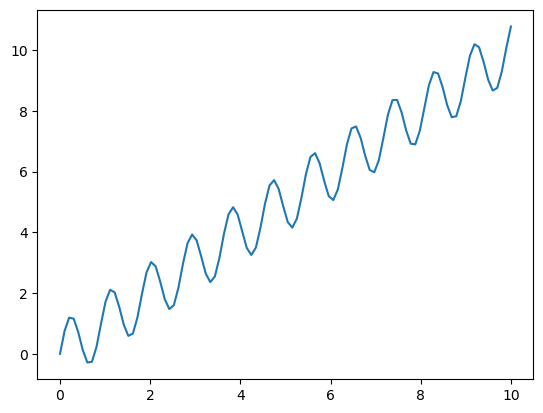

In [8]:
from matplotlib import pyplot as plt


x = np.linspace(0, 10, 100)
y = np.sin(x*7) + x
plt.plot(x, y)

In [24]:
lr = LinearRegressor(True)
lr.fit(x, y, method = "gradient_descent", learning_rate=0.005, iterations=1000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [25]:
preds = lr.predict(x)

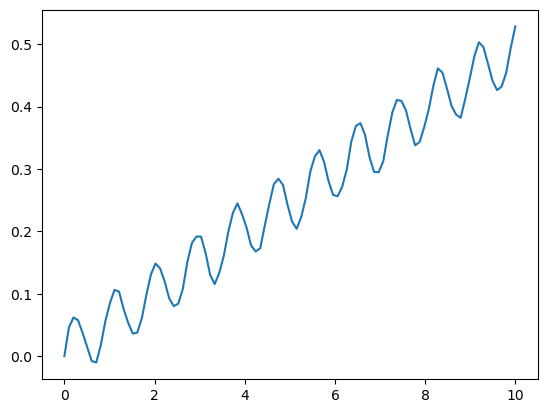

In [26]:
plt.plot(x, preds)

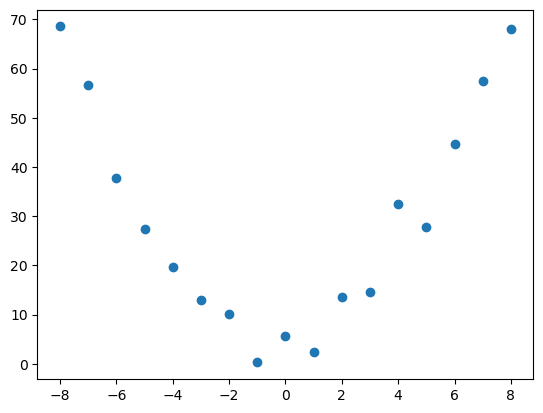

In [9]:
xx = np.linspace(-8, 8, 17)
yy = np.array([68.56, 56.64, 37.8, 27.38, 19.62, 12.97, 10.02, 0.25, 5.71, 2.48, 13.58, 14.64, 32.53, 27.84, 44.75, 57.47, 68.13])
# yy = xx ** 2
plt.scatter(xx, yy)

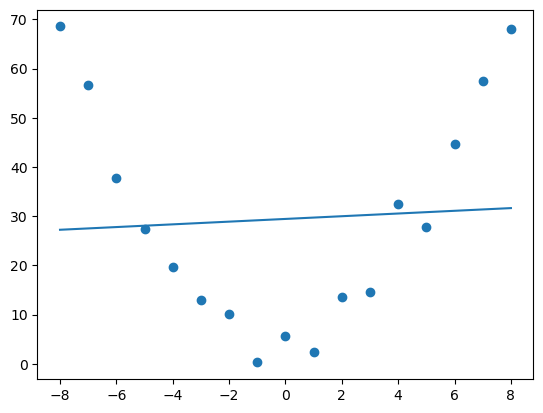

In [10]:
from sklearn.linear_model import LinearRegression
l = LinearRegression()
l.fit(xx.reshape((-1,1)), yy.reshape((-1,1)))
x_preds = l.predict(xx.reshape((-1,1)))
plt.scatter(xx,yy)
plt.plot(xx, x_preds)

In [11]:
l.coef_, l.intercept_

(array([[0.27541667]]), array([29.43352941]))

In [12]:
np.corrcoef(xx, yy)

array([[1.        , 0.06131934],
       [0.06131934, 1.        ]])

In [13]:
from sklearn.metrics import r2_score
r2_score(yy, x_preds)** 0.5

0.061319341332037904

In [14]:
yy, xx.reshape(-1,1)

(array([68.56, 56.64, 37.8 , 27.38, 19.62, 12.97, 10.02,  0.25,  5.71,
         2.48, 13.58, 14.64, 32.53, 27.84, 44.75, 57.47, 68.13]),
 array([[-8.],
        [-7.],
        [-6.],
        [-5.],
        [-4.],
        [-3.],
        [-2.],
        [-1.],
        [ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.]]))

In [15]:
r2_score(yy, xx.reshape(-1,1))

-1.811584772478124

In [24]:
l= LinearRegressor(True)
# x_fit = np.vstack((xx,xx**2)).T
l.fit(xx, yy, "gradient_descent", 0.05, 5000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

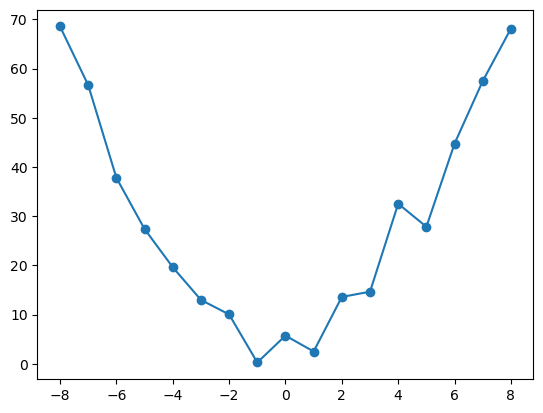

In [25]:
x_preds = l.predict(xx)
plt.scatter(xx,yy)
plt.plot(xx, x_preds)